In [12]:
import altair as alt
from bs4 import BeautifulSoup
from vega_datasets import data
import gpdvega
import geopandas
import json
import shapely
import re
from matplotlib import pyplot as plt
%matplotlib inline

# Extract locations from XML data

In [85]:
portraitRaw = open('../portrait.xml').read()
portraitSoup = BeautifulSoup(portraitRaw)
geos = portraitSoup.find_all('geo')

In [86]:
geotext = [item.text for item in geos]

In [87]:
lineNos = [int(item.parent.parent.find_previous('lb').attrs['n']) for item in geos]

In [88]:
points = [shapely.geometry.point.Point([float(x) for x in pt.strip().split()[-1::-1]]) for pt in geotext]

In [89]:
def clean(text): 
    return re.sub('\s+', ' ', text.strip().replace('\n', ' '))

In [90]:
names = [clean(item.parent.parent.find('placename').text.strip()) for item in geos]

In [91]:
gdf = geopandas.GeoDataFrame({'name': names, 'lineNo': lineNos, 'geometry': points})

In [92]:
gdf.head()

,name,lineNo,geometry
0,Leicester Abbey,10112,POINT (-1.132563 52.640379)
1,Leicester Abbey,10116,POINT (-1.132563 52.640379)
2,Mozambique Channel,10132,POINT (41.280858 -18.615949)
3,the longest river in America,10133,POINT (-90.199404 38.627003)
4,Wicklow Hotel,10154,POINT (-6.260651 53.342872)


# Use Natural Earth Land Vectors

From: https://www.naturalearthdata.com/downloads/50m-physical-vectors/50m-land/

In [21]:
gdf2 = geopandas.read_file('mapData/ne_50m_land.shp')

In [22]:
gdf.head()

,name,lineNo,geometry
0,Leicester Abbey,10112,POINT (-1.132563 52.640379)
1,Leicester Abbey,10116,POINT (-1.132563 52.640379)
2,Mozambique Channel,10132,POINT (41.280858 -18.615949)
3,the longest river in America,10133,POINT (-90.199404 38.627003)
4,Wicklow Hotel,10154,POINT (-6.260651 53.342872)


In [23]:
gdf2.head()

,scalerank,featurecla,min_zoom,geometry
0,0,Land,1.5,"POLYGON ((179.99921875 -16.16855468750001, 179..."
1,0,Land,4.0,"POLYGON ((177.2341796875 -17.14707031250001, 1..."
2,0,Land,4.0,"POLYGON ((127.37265625 0.7913085937499886, 127..."
3,0,Land,3.0,POLYGON ((-81.33481445312499 24.65048828124999...
4,0,Land,4.0,"POLYGON ((-80.82939453124999 24.803662109375, ..."


# Apply Mercator projection

In [24]:
gdf.crs = {'init': 'epsg:4326'}
# gdf.crs = {'init': 'epsg:27700'}
# gdf2.crs = {'init': 'epsg:27700'}

In [25]:
gdf.crs

{'init': 'epsg:4326'}

In [26]:
mercator, britain, americas, web = (4326, 27700, 2163, 3857)
#gdf = gdf.to_crs(epsg=web)


In [27]:
gdf.crs, gdf2.crs

({'init': 'epsg:4326'}, {'init': 'epsg:4326'})

# Convert line numbers to percentages

In [28]:
def lineToPercent(lineNo): 
    """ Convert the line number to a percentage in the narrative time of the novel,
    i.e., 0% is the beginning of the novel, 100% is the end. """
    maxLines = {1: 1848, 2: 1458, 3: 1584, 4: 922, 5: 2794}
    totalLines = sum(maxLines.values())
    chap = int(str(lineNo)[0])
    linesIntoChap = lineNo - (chap * 10000)
    preceedingLines = sum([maxLines[i] for i in range(1, chap)])
    return (preceedingLines + linesIntoChap) / totalLines

In [29]:
gdf['percentNarrative'] = gdf['lineNo'].apply(lineToPercent)

In [30]:
gdf.head()

,name,lineNo,geometry,percentNarrative
0,Leicester Abbey,10112,POINT (-1.132563 52.640379),0.013014
1,Leicester Abbey,10116,POINT (-1.132563 52.640379),0.013479
2,Mozambique Channel,10132,POINT (41.280858 -18.615949),0.015338
3,the longest river in America,10133,POINT (-90.199404 38.627003),0.015454
4,Wicklow Hotel,10154,POINT (-6.260651 53.342872),0.017894


# Plot

In [93]:

# Slice so that it's only showing the British Isles
gdf = gdf.cx[-11:1,50:58]
gdf2 = gdf2.cx[-11:1,50:58]

# Reproject
gdf = gdf.to_crs(epsg=web)
gdf2 = gdf2.to_crs(epsg=web)

ValueError: Cannot transform naive geometries.  Please set a crs on the object first.

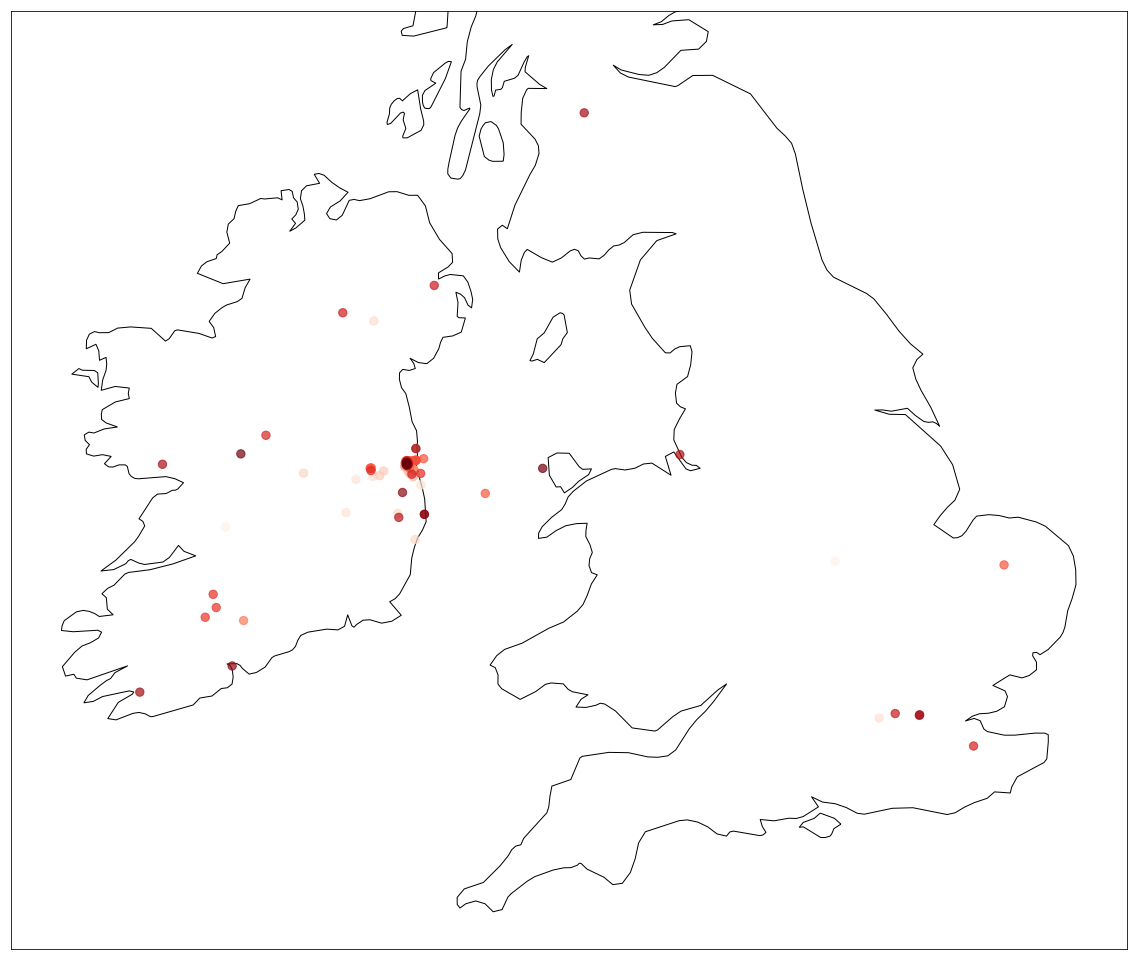

In [32]:
# Setting the figsize width here (20) seems to take effect,
# but not setting the figsize height (40)
fig, ax = plt.subplots(figsize=(20,20))

gdf2.plot(ax=ax, color='white', edgecolor='black')
gdf.plot(ax=ax, marker='o', c=(gdf.percentNarrative * 256), cmap='Reds', markersize=70, alpha=0.7)

plt.ylim([6400000, 7650000])
plt.xticks([])
plt.yticks([])
plt.savefig('/home/jon/Code/article-jjq/images/portrait-map.svg')
plt.show()

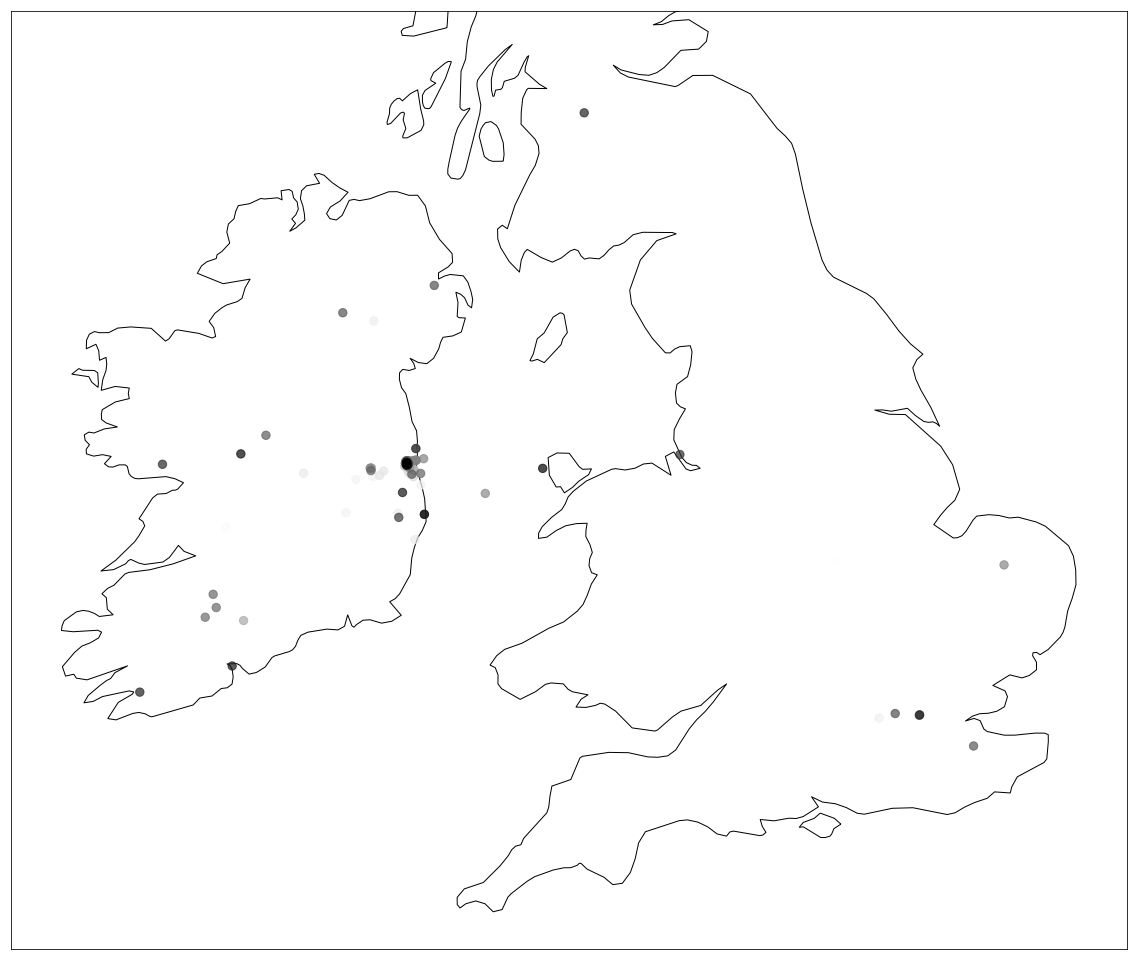

In [33]:
# Setting the figsize width here (20) seems to take effect,
# but not setting the figsize height (40)
fig, ax = plt.subplots(figsize=(20,20))

gdf2.plot(ax=ax, color='white', edgecolor='black')
gdf.plot(ax=ax, marker='o', c=(gdf.percentNarrative * 256), cmap='Greys', markersize=70, alpha=0.7)

plt.ylim([6400000, 7650000])
plt.xticks([])
plt.yticks([])
plt.savefig('/home/jon/Code/article-jjq/images/portrait-map-bw.svg')
plt.show()